# Swan Project, Analysis of Churners - Team 7
This notebook covers our exploration and prediction of the churning of customers within the Swan database provided.

## 0. Imports

In [1]:
# Import statements and set up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from matplotlib.colors import to_rgb
from matplotlib.patches import Patch

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

two_palette=['#2c3e6c', '#b0c4de']
three_palette = ['#2c3e6c', '#b0c4de', '#98A8B6']
five_palette = ['#2c3e6c', '#b0c4de', '#98A8B6', '#7F8C8D', '#2A2A2A']

## 1. Exploratory Data Analysis
### 1.1. Initial Checks
We first investigated the dataset to explore whether there was any anomalous data, as well as establishing basic insights into which types of customers are likely to churn and why they would do so.

In [2]:
df = pd.read_csv("Project_Data.csv")
print("Data Shape:", df.shape)
print("Data Nulls:\n", df.isna().sum())

Data Shape: (7043, 31)
Data Nulls:
 CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Reason         5174
dtype: int64


We initially briefly investigate the nulls located within Churn Reason to establish the reason for this large number of nulls, finding that there are only nulls for 'Churn Reason' when the customer has not churned, which is wholly logical and thus means the data is consistent still with these nulls.

In [3]:
# this shows that the only null values are for reason when churn value is 0 which is wholly logical.
nullReason = df[df['Churn Reason'].isna()].copy()
nullReason['Churn Value'].value_counts()

Churn Value
0    5174
Name: count, dtype: int64

### 1.2. Renaming columns

We rename the variables to more standard coding practices.

In [4]:
# Rename columns for consistency
df = df.rename(columns={
    'CustomerID': 'customer_id',
    'Churn Label': 'churn_flag',
    'Churn Value': 'churn_value',
    'Churn Reason': 'churn_reason',
    'Tenure Months': 'tenure_months',
    'Monthly Charges': 'monthly_charges',
    'Total Charges': 'total_charges'
})

### 1.3. Demographics of churners
We explore different visualisations of relationships between churners and different features within the dataset.
Prior to doing this, we note that we normalise our values within the graph so that we give a percentage of the total number of people who did or didn't churn. 

- Gender does not affect churn
- Senior citizens have a higher chance to churn
- Partner & Dependents have a lower chance to churn

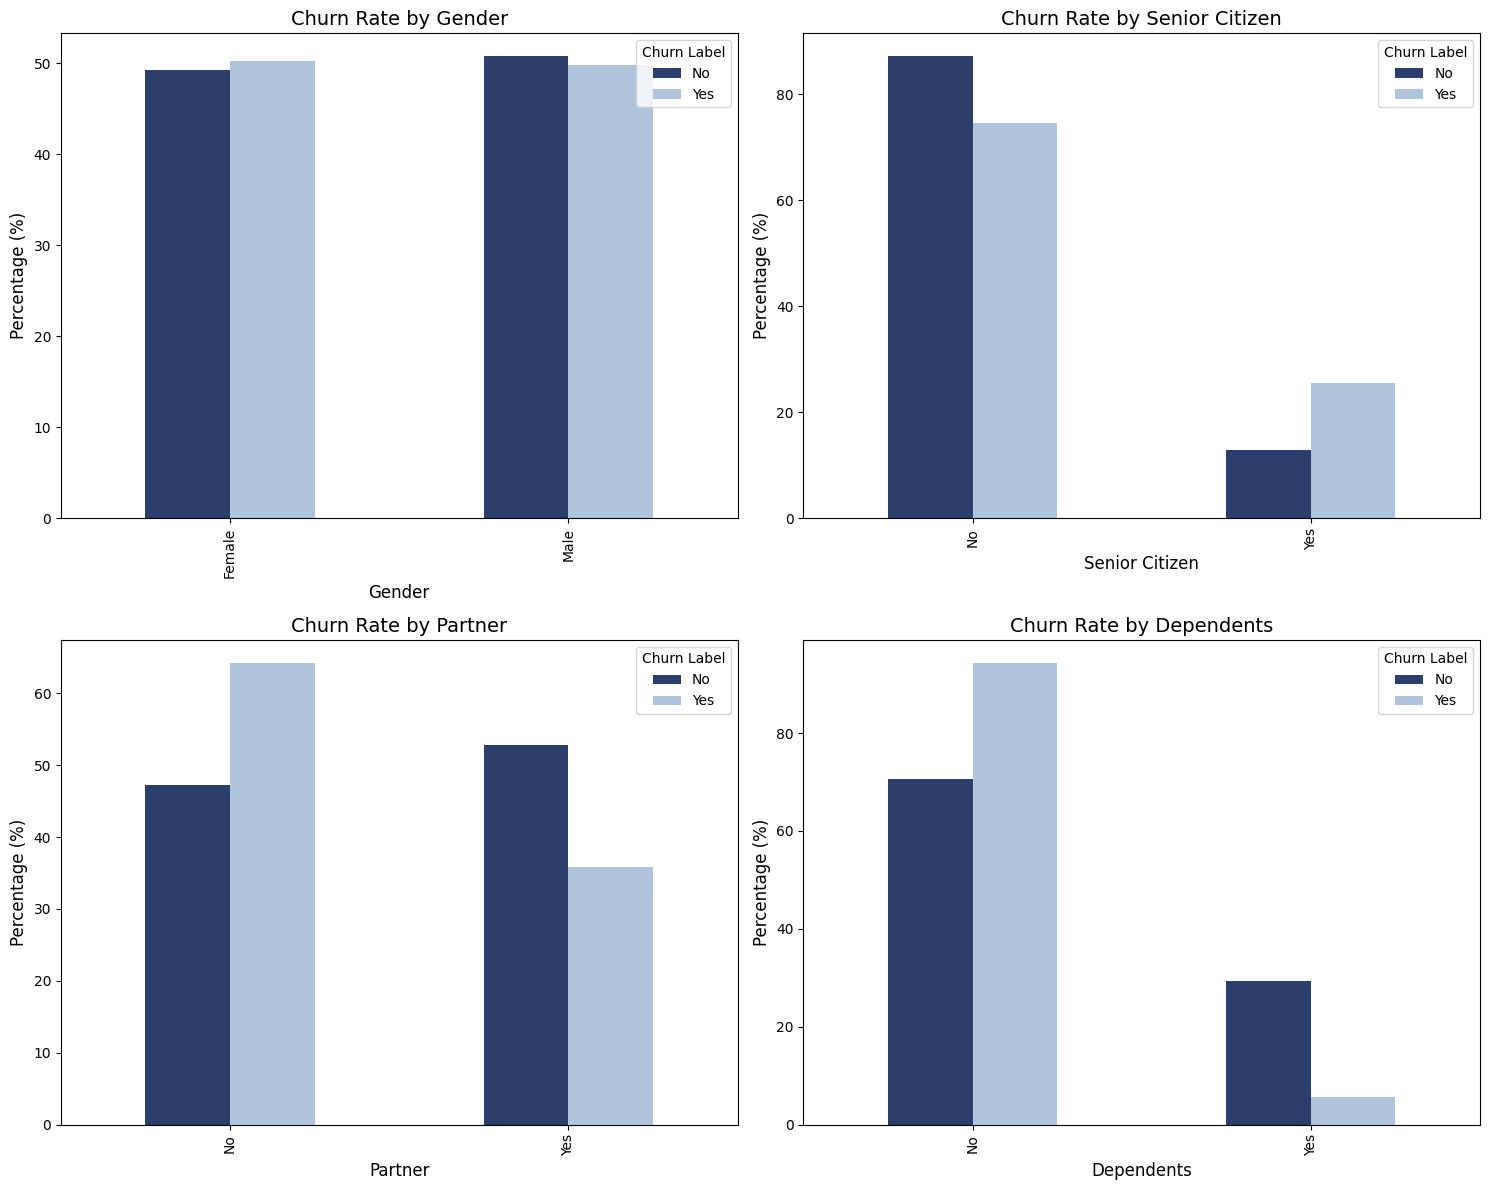

In [5]:
#Demographic Analysis - Cool Visualizations
columns = ['Gender', 'Senior Citizen', 'Partner', 'Dependents']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Loop through columns
for idx, (col) in enumerate(columns):
    # Calculate crosstab with percentages
    crosstab = pd.crosstab(df[col], df['churn_flag'], normalize='columns') * 100
    # Create bar plot
    crosstab.plot(kind='bar', ax=axes[idx], color=two_palette[:len(crosstab.columns)])

    # Set titles and labels
    axes[idx].set_title('Churn Rate by ' + col, fontsize=14)
    axes[idx].set_xlabel(col, fontsize=12)
    # We use percentages so that the data is  scaled appropriately.
    axes[idx].set_ylabel('Percentage (%)', fontsize=12)
    axes[idx].legend(title='Churn Label', loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

These all have the highest churn rate of their respective contractual categories:
- Fiber optic
- Month-month
- Electronic checks

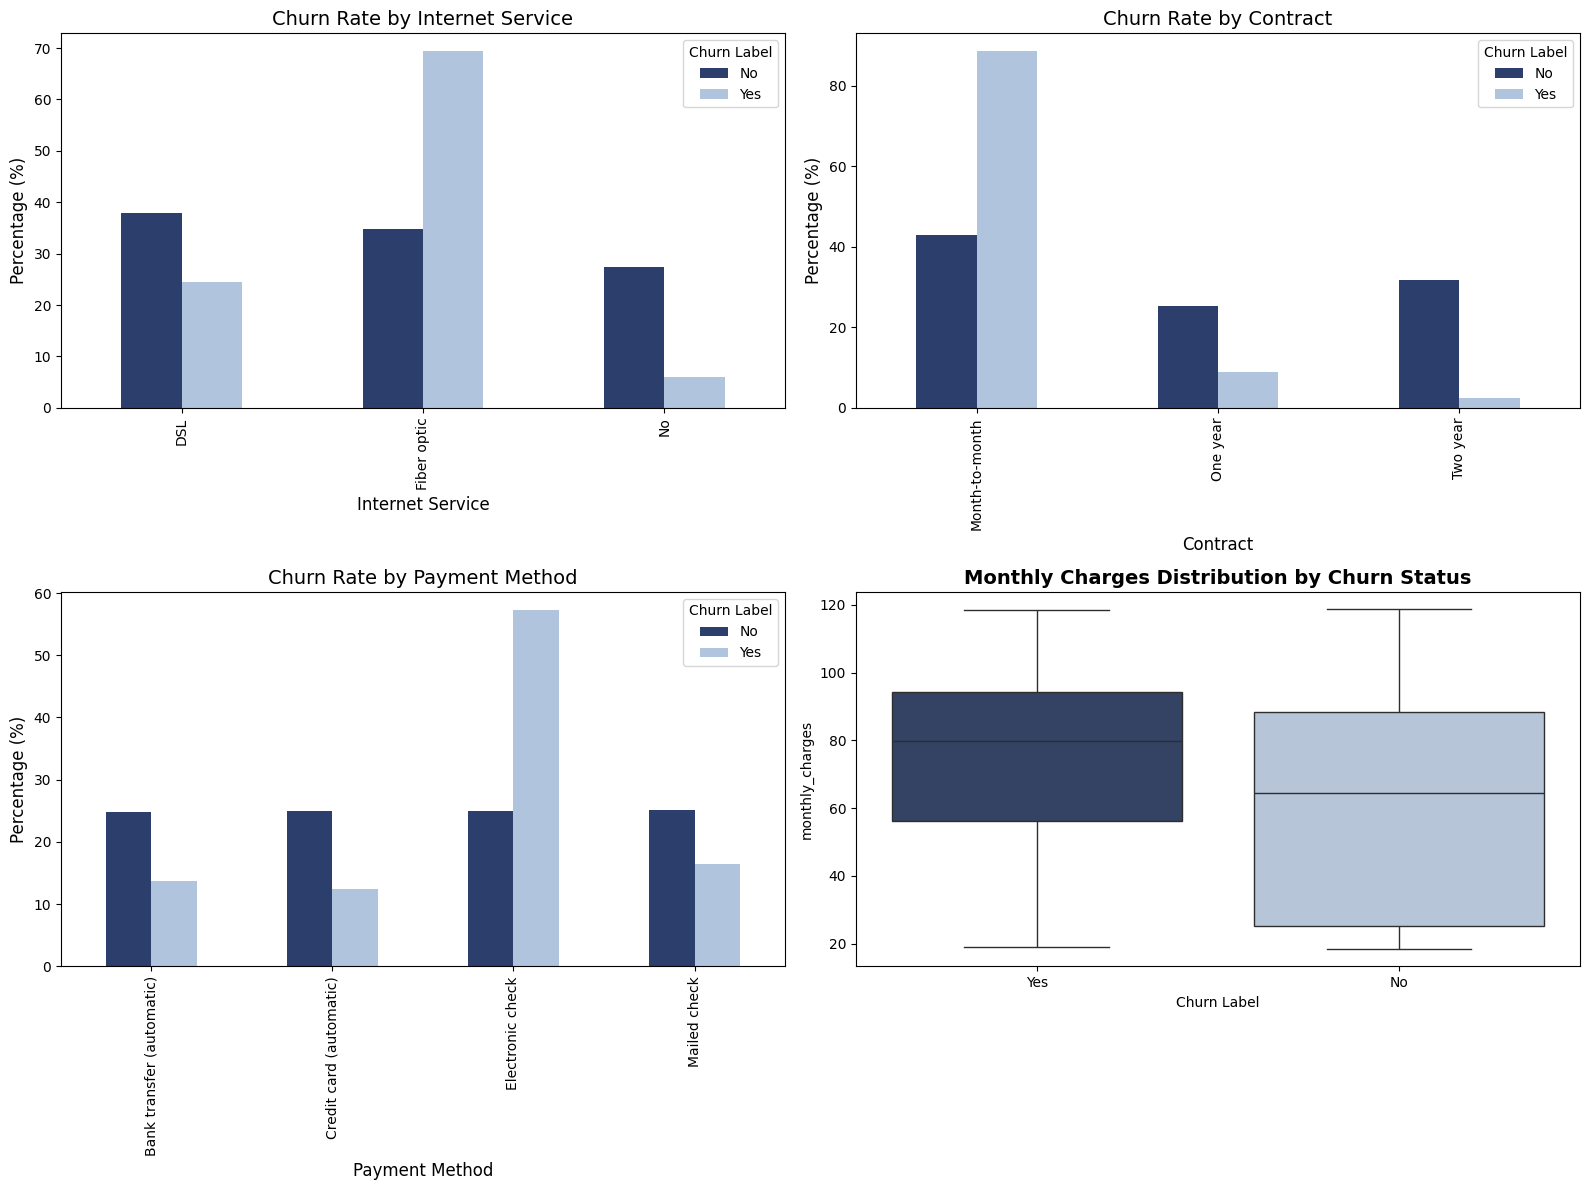

In [6]:
# Payments and Internet Service Graphs
columns = ['Internet Service', 'Contract', 'Payment Method']
# Service Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Loop through columns
for idx, (col) in enumerate(columns):
    # Calculate crosstab with percentages
    crosstab = pd.crosstab(df[col], df['churn_flag'], normalize='columns') * 100
    # Create bar plot
    crosstab.plot(kind='bar', ax=axes[idx], color=two_palette[:len(crosstab.columns)])

    # Set titles and labels
    axes[idx].set_title('Churn Rate by ' + col, fontsize=14)
    axes[idx].set_xlabel(col, fontsize=12)
    # We use percentages so that the data is  scaled appropriately.
    axes[idx].set_ylabel('Percentage (%)', fontsize=12)
    axes[idx].legend(title='Churn Label', loc='upper right', fontsize=10)

sns.boxplot(data=df, x='churn_flag', y='monthly_charges', ax=axes[3], palette=two_palette, hue = 'churn_flag')
axes[3].set_title('Monthly Charges Distribution by Churn Status', fontsize=14, fontweight='bold')
axes[3].set_xlabel('Churn Label')

plt.tight_layout()
plt.show()

Tech add ons such as:
- Online security
- Online backup
- Device protection
- Tech support

All reduce churn rate. TV & Movie streaming services do not reduce churn by a noticeable amount.

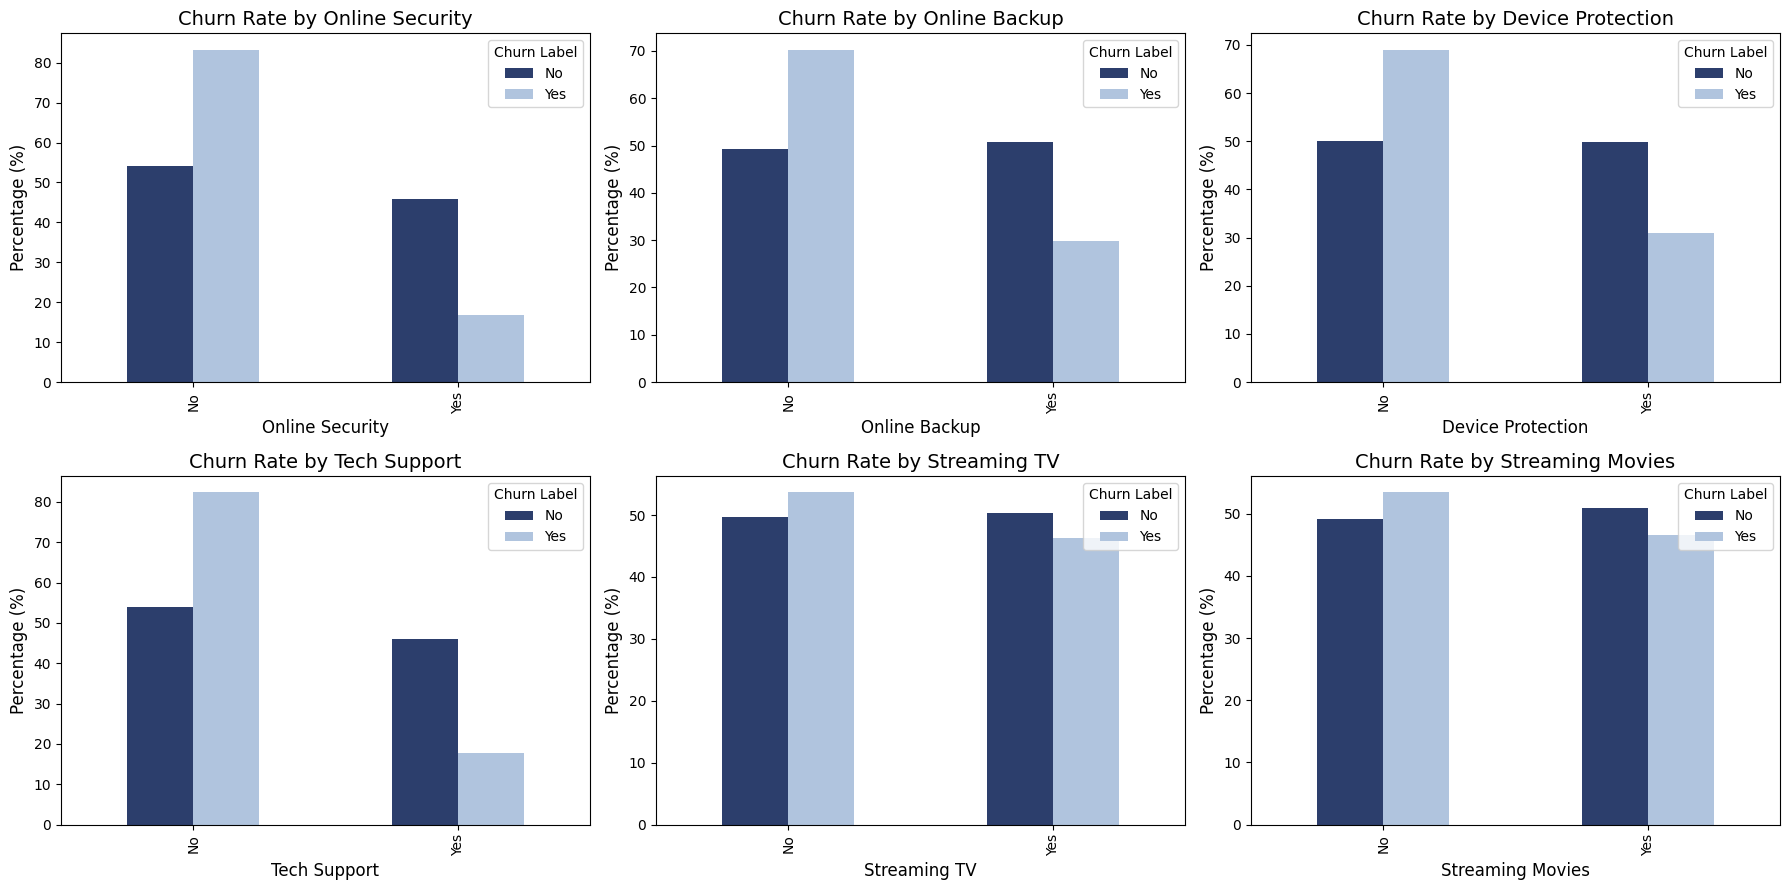

In [7]:
# Columns to analyze
columns = ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support','Streaming TV', 'Streaming Movies']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 9))
axes = axes.flatten()

# Remove rows where InternetService is 'No'
df_internet = df[df['Internet Service'] != 'No']

# Loop through columns
for idx, (col) in enumerate(columns):
    # Calculate crosstab with percentages
    crosstab = pd.crosstab(df_internet[col], df_internet['churn_flag'], normalize='columns') * 100

    # Create bar plot
    crosstab.plot(kind='bar', ax=axes[idx], color=two_palette[:len(crosstab.columns)])

    # Set titles and labels
    axes[idx].set_title('Churn Rate by ' + col, fontsize=14)
    axes[idx].set_xlabel(col, fontsize=12)
    # We use percentages so that the data is  scaled appropriately.
    axes[idx].set_ylabel('Percentage (%)', fontsize=12)
    axes[idx].legend(title='Churn Label', loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

Neither Phone service nor Multiple lines seem to affect churn by a reasonable amount

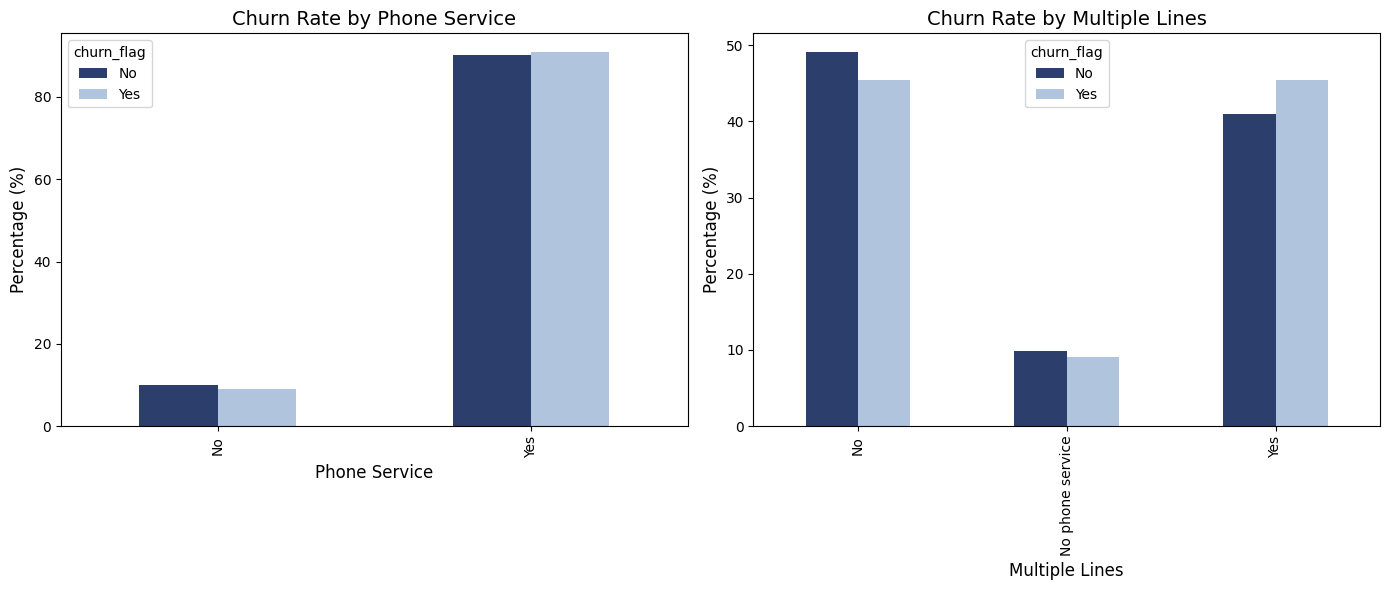

In [8]:
# Columns to analyze
columns = ['Phone Service', 'Multiple Lines']

# Create subplots
fig, axes = plt.subplots(1, len(columns), figsize=(14, 6))

# Loop through columns
for idx, (col) in enumerate(columns):
    # Calculate crosstab with percentages
    crosstab = pd.crosstab(df[col], df['churn_flag'], normalize='columns') * 100

    # Create horizontal bar plot
    crosstab.plot(kind='bar', ax=axes[idx], color=two_palette[:len(crosstab.columns)])

    # Set titles and labels
    axes[idx].set_title('Churn Rate by ' + col, fontsize=14)
    axes[idx].set_xlabel(col, fontsize=12)
    axes[idx].set_ylabel('Percentage (%)', fontsize=12)

plt.tight_layout()
plt.show()

Churn is vastly affected by tenure  
Customers that stay with the company for longer than a month sharply increase their retention rate [add value here]

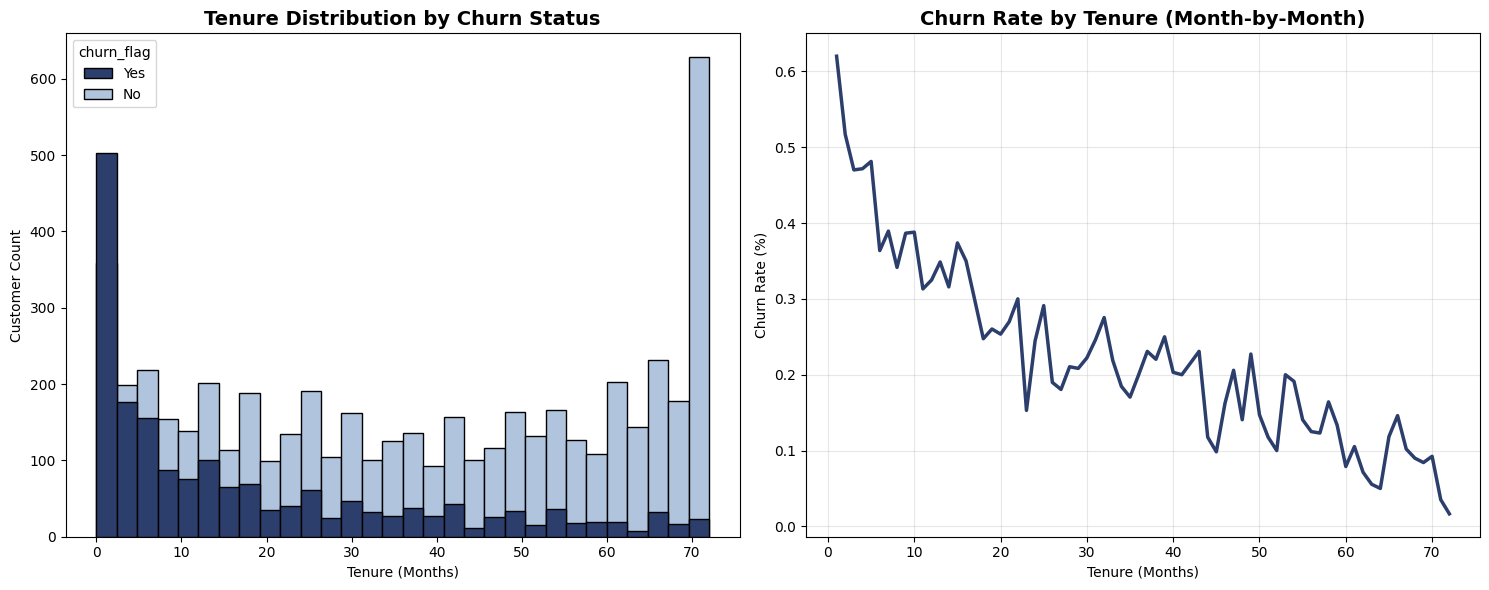

In [9]:
# Tenure Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# LHS
sns.histplot(
    data=df,
    x='tenure_months',
    hue='churn_flag',
    bins=30,
    ax=axes[0],
    palette=two_palette,
    alpha=1
)
axes[0].set_title('Tenure Distribution by Churn Status', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tenure (Months)')
axes[0].set_ylabel('Customer Count')

# RHS
tenure_month_churn = (
    df.groupby('tenure_months')['churn_value']
    .mean()
    .reset_index()
    .rename(columns={'churn_value': 'churn_rate'})
)
tenure_month_churn = tenure_month_churn[tenure_month_churn['tenure_months'] > 0]
sns.lineplot(
    data=tenure_month_churn,
    x='tenure_months',
    y='churn_rate',
    ax=axes[1],
    color='#2c3e6c',
    linewidth=2.5
)
axes[1].set_title('Churn Rate by Tenure (Month-by-Month)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tenure (Months)')
axes[1].set_ylabel('Churn Rate (%)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 1.3. Churn Drivers
We investigated what led to customers churning.  
The top reasons were due to Poor Customer Support and Competetors having higher download speed/more data

[LOOK INTO FIBER OPTIC/DSL SPLIT OF COMPETETOR REASONS?]

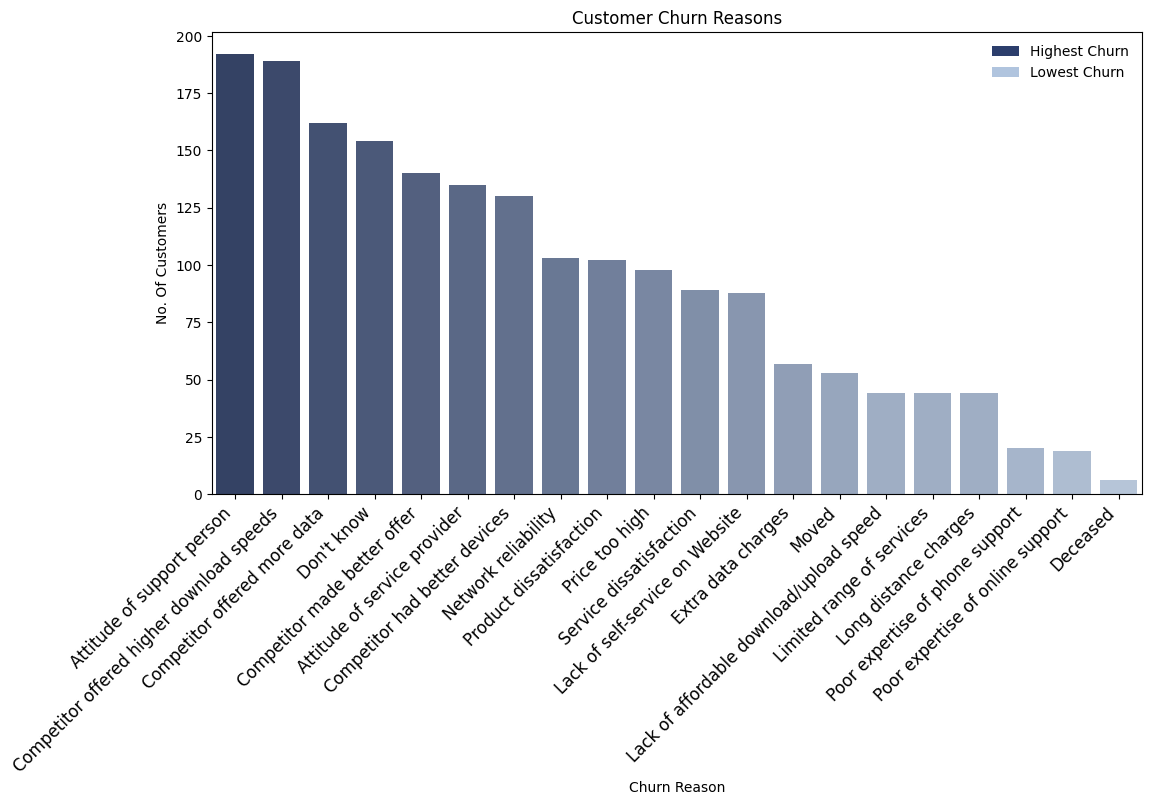

In [10]:
# Graphing the top reasons customers gave for churning
# Convert hex to RGB tuples


start_rgb = to_rgb(five_palette[1])
end_rgb = to_rgb(five_palette[0])

# Create a custom palette by interpolating between the two
n_colors = 18  # Number of colors in the palette
palette = [
    (
        start_rgb[0] + (end_rgb[0] - start_rgb[0]) * i / (n_colors - 1),
        start_rgb[1] + (end_rgb[1] - start_rgb[1]) * i / (n_colors - 1),
        start_rgb[2] + (end_rgb[2] - start_rgb[2]) * i / (n_colors - 1)
    )
    for i in range(n_colors)
]
churnValue_Reason = df[['churn_value', 'churn_reason']]
churnValue_Reason
churned = churnValue_Reason[churnValue_Reason['churn_value'] == 1]
reasonCounts = churned.value_counts()
reasonCounts = pd.DataFrame(reasonCounts).reset_index().rename(columns={'index': 'churn_reason', 0: 'Count'})
reasonCounts
plt.figure(figsize=(12,6))
sns.barplot(x=reasonCounts['churn_reason'], y=reasonCounts['count'], palette=palette, hue = reasonCounts['count'])
plt.xlabel('Churn Reason')
plt.xticks(rotation= 45, # rotating labels
           horizontalalignment = 'right', # aligning them with the bars
           fontweight = 'light',
           fontsize = 'large' # setting the fonts
          )
plt.ylabel('No. Of Customers')
plt.title('Customer Churn Reasons')
# Create custom legend with first and last colors
legend_elements = [
    Patch(facecolor=palette[-1], label='Highest Churn'),
    Patch(facecolor=palette[0], label='Lowest Churn')
]
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1), frameon=False)
plt.show()

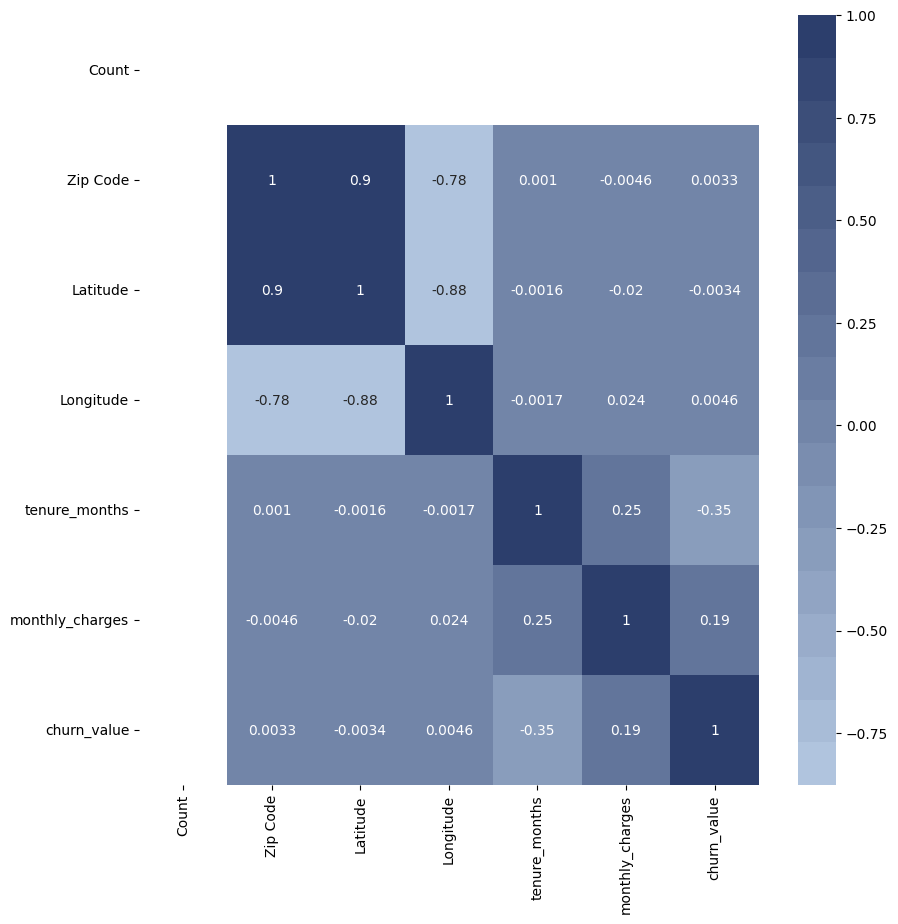

In [11]:
# Creating correlation to see what factors have a negative correlation with churn value.
plt.figure(figsize = (10,10))
sns.heatmap(data = df.corr(numeric_only = True),
            cmap = palette, 
            annot = True)
plt.show()

In [12]:
def churn_rate_summary_fixed(df, features, churn_col='churn_flag'):
    """
    Creates a table with churn % for 'Yes' and 'No' values and Δ%.
    Handles columns with 'No internet service' or 'No phone service'.
    """
    results = []

    df_local = df.copy()

    # Normalize "No internet service"/"No phone service" → "No"
    df_local = df_local.replace({
        'No internet service': 'No',
        'No phone service': 'No'
    })

    for col in features:
        if col not in df_local.columns:
            continue

        churn_table = (
            df_local.groupby(col)[churn_col]
            .apply(lambda x: (x == 'Yes').mean() * 100 if df[churn_col].dtype == 'object' else x.mean() * 100)
        )

        yes_rate = churn_table.get('Yes', np.nan)
        no_rate  = churn_table.get('No', np.nan)
        delta    = yes_rate - no_rate if (not np.isnan(yes_rate) and not np.isnan(no_rate)) else np.nan

        results.append({
            'Feature': col,
            'Churn % (Yes)': round(yes_rate, 2) if not np.isnan(yes_rate) else None,
            'Churn % (No)': round(no_rate, 2) if not np.isnan(no_rate) else None,
            'Δ % (Yes - No)': round(delta, 2) if not np.isnan(delta) else None
        })

    return pd.DataFrame(results).sort_values(by='Δ % (Yes - No)', ascending=False).reset_index(drop=True)


# Include both demographics & service features
features = [
    'Paperless Billing', 'Phone Service', 'Multiple Lines',
    'Online Security', 'Online Backup', 'Device Protection',
    'Tech Support', 'Streaming TV', 'Streaming Movies'
]

summary_table = churn_rate_summary_fixed(df, features)
summary_table

,Feature,Churn % (Yes),Churn % (No),Δ % (Yes - No)
0,Paperless Billing,33.57,16.33,17.24
1,Streaming TV,30.07,24.33,5.74
2,Streaming Movies,29.94,24.38,5.56
3,Multiple Lines,28.61,25.02,3.59
4,Phone Service,26.71,24.93,1.78
5,Device Protection,22.50,28.65,-6.15
6,Online Backup,21.53,29.17,-7.64
7,Tech Support,15.17,31.19,-16.02
8,Online Security,14.61,31.33,-16.72


### Exploratory Data Analysis Conclusion
To summarise our primary findings from our EDA, we conclude that:
* In regards to demographics, the main takeaways are that senior citizens are the primary area for concern in regards to a higher churn rate.
* Customers who have Fibre Optic, as well as ones who are under a month to month contract are both likely to churn and may need incentives to stay. This could come in the form of raising awareness about the benefits of brand loyalty. This also matches well with the fact that *Tenure Months* were found to be the biggest negative correlator to people churning, meaning that it is a strong incentive that leads to people staying.
* Tech add ons such as Online Security and Backup all seem to be effective at reducing churn, whilst streaming add ons do not have much of an impact.
* The primary reasons given by customers for churning came down to disappointment in customer support, or better offerings from competitors. Thus, if there was an area to focus on competitive offerings, it would be best in improving the service given to customers using Fibre Optic potentially, for example.

With the data explored and insights established, we moved to investigating two seperate models to ensure we have an optimal method with which to generate the risk of any specific customer churning.


## 2. Modelling Churn Risk
We begin by creating a basic model from which we can begin to assess the potential risk of customers churning.

Make logistic regression & random forest  
Select best on accuracy & f1 score  
Find top 500 list & complete customer churn % chance  

In [13]:
# Feature engineering function, maps binary columns to integers (0 and 1)
def feature_engineering(df):
    df_local = df.copy()

    # Convert gender to numeric
    df_local['Gender'] = df_local['Gender'].map({'Male': 0, 'Female': 1})

    # Binary yes/no features
    fe_list = ['Senior Citizen', 'Partner', 'Dependents',
               'Phone Service', 'Paperless Billing']
    for feature in fe_list:
        if feature in df_local.columns:
            df_local[feature] = df_local[feature].map({'No': 0, 'Yes': 1})

    # Internet-related categorical features (one-hot encode)
    internet_list = [
        'Online Security', 'Online Backup', 'Device Protection',
        'Tech Support', 'Streaming TV', 'Streaming Movies', 'Internet Service',
        'Contract', 'Payment Method'
    ]
    df_local = pd.get_dummies(
        data=df_local,
        columns=internet_list,
        drop_first=True,
        dtype='int'
    )

    # Multiple Lines mapping
    if 'Multiple Lines' in df_local.columns:
        df_local['Multiple Lines'] = df_local['Multiple Lines'].map({
            'No': 0,
            'Yes': 1,
            'No phone service': 0
        })

    return df_local

df_eng = feature_engineering(df)

In [14]:
# Features and target
drop_cols = [
    'Country',
    'State',
    'City',
    'Zip Code',
    'Lat Long',
    'Latitude',
    'Longitude',
    'customer_id',
    'churn_flag',
    'churn_value',
    'churn_reason',
    'Internet Service',
    'Contract',
    'Tenure Group',
    'Count'
    'churn_risk',
    'churn_risk_log'
    ] # We extract any features that are objects to avoid mislabelling them, along with the target.

X = df_eng.drop(columns=drop_cols, errors='ignore')

y = df_eng['churn_flag']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
### Fill missing values
median = X_train.loc[~(X_train['total_charges'] == ' ')]['total_charges'].astype('float').median()
print(f'The median value of total charges is {median}')
X_train['total_charges'] = X_train['total_charges'].replace({' ': median})
X_test['total_charges'] = X_test['total_charges'].replace({' ': median})

The median value of total charges is 1388.0


In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Classification Report:
               precision    recall  f1-score   support

          No       0.84      0.91      0.87      1009
         Yes       0.71      0.55      0.62       400

    accuracy                           0.81      1409
   macro avg       0.77      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

ROC AUC: 0.8535344400396431


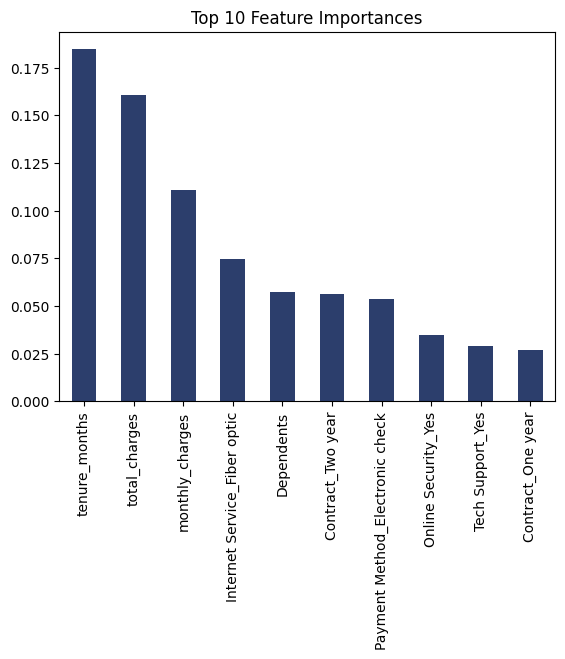

In [17]:
# Random Forest
# rf = RandomForestClassifier(n_estimators = 50)
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 20],
#     'min_samples_split': [2, 5],
#     'max_features': ['sqrt', 'log2'],
#     'class_weight': ['balanced', None]
# }
# gs = GridSearchCV(rf, param_grid, cv=5)
# gs.fit(X_train_scaled, y_train)
# print(gs.best_score_)

# gs.best_params_
# ^- the above piece of code generated the following parameters as optimal, but is excluded due to its slightly lengthy runtime of ~1 minute
rf = RandomForestClassifier(n_estimators = 200, max_depth = 10, max_features = 'sqrt', min_samples_split = 5)
rf.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf.predict(X_test_scaled)
y_prob = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances[:10].plot(kind='bar', color='#2c3e6c')
plt.title("Top 10 Feature Importances")
plt.show()

In [18]:
# Logistic Regression

log_reg = LogisticRegression(max_iter=1000)

param_grid = [
    {'penalty': ['l2'], 'solver': ['lbfgs', 'newton-cg', 'saga'], 'C': [0.01, 0.1, 1, 10]},
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [0.01, 0.1, 1, 10]}
]
 

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_scaled, y_train)

y_pred_log = grid_search.predict(X_test_scaled)

y_prob_log = grid_search.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))
print("ROC AUC:", roc_auc_score(y_test, y_prob_log))





Classification Report:
               precision    recall  f1-score   support

          No       0.84      0.89      0.87      1009
         Yes       0.68      0.58      0.62       400

    accuracy                           0.80      1409
   macro avg       0.76      0.73      0.75      1409
weighted avg       0.80      0.80      0.80      1409

ROC AUC: 0.8539358275520318


## Extracting the customer list

We now use the the better of the two models (Random Forest) we have obtained to create our two lists of customers as required. **Note**: We made the conscious choice to only include the *customer ID* within the list of top 500 customers likely to churn as a form of abstraction to ensure that only the information necessary for the mailing list is given. Along with this, to ensure the full set of data is provided witin the full list of churn risk of each customer, we still included the top 500 customers likely to churn, along with more information than is given in the top 500 list.

In [19]:
ids = df_eng[['customer_id', 'churn_flag']] ## Store ids for later
X_final =df_eng.drop(columns=drop_cols, errors='ignore').copy() ## drop columns so that we are using training columns
X_final['total_charges'] = X_final['total_charges'].replace({' ': median}) ## fill values
X_final = scaler.transform(X_final)

df_eng['churn_risk'] = rf.predict_proba(X_final)[:, 1]
df_eng['churn_risk_log'] = grid_search.predict_proba(X_final)[:, 1]
sorted_by_rf = df_eng.sort_values(by = 'churn_risk', ascending=False)
sorted_by_log = df_eng.sort_values(by = 'churn_risk_log', ascending=False)

In [20]:
non_churners = sorted_by_rf.loc[sorted_by_rf['churn_flag'] == 'No']
top_500_customers = non_churners[['customer_id']].iloc[ :500, : ]
top_500_customers.to_csv("top_500_customers.csv", index=False)

In [22]:
customer_risk_list = non_churners[['customer_id', 'churn_risk']]
customer_risk_list.to_csv("customer_churn_risk.csv", index=False)